In [ ]:
from enum import Enum, IntEnum


class T(IntEnum):
    A = 0


type(T.A)
int(T.A)
T.A == 0

In [ ]:
import os
import pickle
import random
with open("./pickles/cdf_real2.pickle", "rb") as f:
    vlist = pickle.load(f)
vlist

In [ ]:
from glob import glob
folders = ["cropped_faces", "cropped_faces_250", "landmarks", "semantic_videos", "cropped_faces(landmark)"]
files = []
for v in vlist:
    for folder in folders:
        # files.extend(glob(f"/home/od/Desktop/Dataset/DFDC/{folder}/{os.path.split(v)[-1][:-4]}*.*"))
        files.extend(glob(v.replace("videos", folder).replace(".mp4", "*.*")))
files

In [ ]:
len(files), len(vlist)

In [ ]:
for file in files:
    os.remove(file)

In [ ]:
import cv2
import facer
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms.functional import normalize
from preprocessing.extract_faces import get_video_clip, save_video_lossless

# video_path = "/home/od/Desktop/Dataset/CelebDF/Fake/cropped_faces/id0_id1_0000.avi"
video_path = "/home/od/Desktop/Dataset/DFDC/videos/nwpjsjarju.mp4"
fps, frames = get_video_clip(video_path, stride=1)

In [ ]:
frame_indices = [i for i in range(0, 300, 1)]

In [ ]:
landmarks = np.load(f"/home/od/Desktop/Dataset/DFDC/test_lm/rfwtnztcsj.npy")

In [ ]:
landmarks.shape

In [ ]:
landmarks.reshape(-1, 2).shape

In [ ]:
# import random
# i = random.randrange(0, len(frame_indices))
# print(i)
# plt.figure(figsize=(25, 15))
# plt.imshow(cv2.cvtColor(frames[frame_indices[i]], cv2.COLOR_BGR2RGB))
# plt.scatter(landmarks[i, :, 0], landmarks[i, :, 1], alpha=0.5, s=1)

In [ ]:
import cv2
import facer
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms.functional import normalize
from preprocessing.extract_faces import get_video_clip, save_video_lossless

# video_path = "/home/od/Desktop/Dataset/CelebDF/Fake/cropped_faces/id0_id1_0000.avi"
video_path = "/stock/FaceForensicC23/videos/NT/217_117.mp4"
fps, frames = get_video_clip(video_path, stride=1)

In [ ]:
class FaceData:
    def __init__(self, _lm, _bbox, _idx):
        self.ema_lm = _lm
        self.lm = [_lm]
        self.bbox = [_bbox]
        self.idx = [_idx]

    def last(self):
        return self.ema_lm

    def add(self, _lm, _bbox, _idx):
        self.ema_lm = self.ema_lm * 0.5 + _lm * 0.5
        self.lm.append(_lm)
        self.bbox.append(_bbox)
        self.idx.append(_idx)

    def __len__(self):
        return len(self.lm)

In [ ]:
import pickle
with open("./pickles/217_117.pickle", "rb") as f:
    frame_faces = pickle.load(f)

In [ ]:
face_dbs = []
for faces, index in zip(frame_faces, frame_indices):
    frame_landmarks = np.stack([face["landmarks"] for face in faces])
    matched_indices = []

    for face_data in face_dbs:

        lm_diff = np.sum(
            np.linalg.norm(frame_landmarks - face_data.last(), axis=-1),
            axis=1
        ) / frame_landmarks.shape[1]

        if (np.min(lm_diff) > 100):
            continue

        closest_idx = np.argmin(lm_diff)
        matched_indices.append(closest_idx)
        face_data.add(faces[closest_idx]["landmarks"], faces[closest_idx]["bbox"], index)

    for i, face in enumerate(faces):
        if i in matched_indices:
            continue
        else:
            _landmark = face['landmarks']
            _bbox = face['bbox']
            face_dbs.append(FaceData(_landmark, _bbox, index))

In [ ]:
print(len(face_dbs), len(face_dbs[0].lm), len(frames))

In [ ]:
len(sorted(face_dbs, key=lambda x: len(x), reverse=True)[0])

In [ ]:
[i for i in range(0, len(frames)) if not i in face_dbs[0].idx]

In [ ]:
import random
fid = 0
i = random.randrange(0, len(face_dbs[fid]))
i = 210
landmarks = face_dbs[fid].lm[i]
plt.figure(figsize=(25, 15))
plt.imshow(cv2.cvtColor(frames[face_dbs[fid].idx[i]], cv2.COLOR_BGR2RGB))
plt.scatter(landmarks[:, 0], landmarks[:, 1], alpha=0.5, s=5)

In [ ]:
import random
idx = 211
faces = [face["landmarks"] for face in frame_faces[idx]]
print(len(faces))
landmarks = np.stack(faces).reshape((-1, 2))
plt.figure(figsize=(25, 15))
plt.imshow(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB))
plt.scatter(landmarks[:, 0], landmarks[:, 1], alpha=0.5, s=5)

In [5]:
# Load FaRL weights
import torch
from src.clip import clip
device = "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.to(device)
farl_state = torch.load("./misc/FaRL-Base-Patch16-LAIONFace20M-ep16.pth")
model.load_state_dict(farl_state["state_dict"], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['visual.mask_token', 'visual.lm_transformer.resblocks.0.attn.in_proj_weight', 'visual.lm_transformer.resblocks.0.attn.in_proj_bias', 'visual.lm_transformer.resblocks.0.attn.out_proj.weight', 'visual.lm_transformer.resblocks.0.attn.out_proj.bias', 'visual.lm_transformer.resblocks.0.ln_1.weight', 'visual.lm_transformer.resblocks.0.ln_1.bias', 'visual.lm_transformer.resblocks.0.mlp.c_fc.weight', 'visual.lm_transformer.resblocks.0.mlp.c_fc.bias', 'visual.lm_transformer.resblocks.0.mlp.c_proj.weight', 'visual.lm_transformer.resblocks.0.mlp.c_proj.bias', 'visual.lm_transformer.resblocks.0.ln_2.weight', 'visual.lm_transformer.resblocks.0.ln_2.bias', 'visual.ln_lm.weight', 'visual.ln_lm.bias', 'visual.lm_head.weight', 'visual.lm_head.bias'])

{'crop_height': 111, 'crop_width': 111, 'h_start': 0.7692307692287969, 'w_start': 0.23076923076863903}


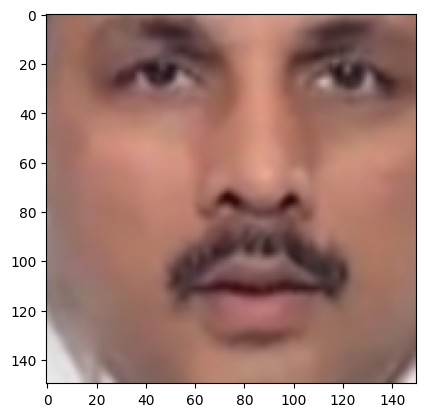

In [215]:
# Albumentation Effect Test Site
import cv2
import torchvision
import albumentations as alb
from matplotlib import pyplot as plt
vid_reader = torchvision.io.VideoReader(
    "datasets/ffpp/real/c23/videos/000.avi",
    "video"
)
vid_reader.seek(2.5)
image = next(vid_reader)
del vid_reader

x = alb.ReplayCompose(
    [
        # alb.RandomCropFromBorders(0.5,0.5,0.5,0.5,True)
        alb.RandomResizedCrop(150,150,scale=(0.5,0.8),ratio=(1,1),always_apply=True)
        # alb.RandomCropNearBBox(always_apply=True)
        # alb.RandomScale((-0.5,-0.1),always_apply=True),
        # alb.Resize(150,150)
        # alb.Resize(150,150,always_apply=1)
        # alb.Affine([0.5,1.0],keep_ratio=True,always_apply=True),
        # alb.Affine([1.5,2.0],keep_ratio=True,always_apply=True),
    ],
    p=1.
)

image = image["data"].numpy().transpose((1,2,0))
result = x(image=image)
image = result["image"]
print(result["replay"]["transforms"][0]["params"])
# image = cv2.cvtColor(image.transpose((1,2,0)),cv2.COLOR_BGR2RGB)
plt.imshow(image)